#### Generate Synthetic Dataset

In [2]:
import numpy as np
import pandas as pd

np.random.seed(42)

# -----------------------------
# 1. Basic user population
# -----------------------------
n = 12000
user_ids = np.arange(1, n+1)

countries = np.random.choice(
    ["DE", "IN", "US", "UK", "FR"],
    size=n,
    p=[0.22, 0.28, 0.25, 0.15, 0.10]
)

device_types = np.random.choice(
    ["sensor", "gateway", "tracker"],
    size=n,
    p=[0.5, 0.3, 0.2]
)

plan_types = np.random.choice(
    ["free", "pro", "enterprise"],
    size=n,
    p=[0.55, 0.35, 0.10]
)

# -----------------------------
# 2. Funnel step probabilities
# -----------------------------
# Base probabilities
p_add = 0.90
p_config = 0.75
p_view = 0.60
p_resolve = 0.45

# Segmentation effects
country_factor = {
    "DE": 1.00,
    "IN": 0.92,
    "US": 1.05,
    "UK": 0.98,
    "FR": 0.95
}

plan_factor = {
    "free": 0.90,
    "pro": 1.05,
    "enterprise": 1.15
}

# -----------------------------
# 3. Generate funnel steps
# -----------------------------
device_added = np.random.binomial(1, p_add, n)

device_configured = [
    np.random.binomial(1, p_config * country_factor[c] * plan_factor[p])
    if a == 1 else 0
    for a, c, p in zip(device_added, countries, plan_types)
]

alert_viewed = [
    np.random.binomial(1, p_view * country_factor[c] * plan_factor[p])
    if cfg == 1 else 0
    for cfg, c, p in zip(device_configured, countries, plan_types)
]

alert_resolved = [
    np.random.binomial(1, p_resolve * country_factor[c] * plan_factor[p])
    if v == 1 else 0
    for v, c, p in zip(alert_viewed, countries, plan_types)
]

# -----------------------------
# 4. Generate timestamps
# -----------------------------
signup_dates = pd.to_datetime(
    np.random.choice(pd.date_range("2024-01-01", "2024-06-30"), size=n)
)

def random_time_after(base_dates, min_h=1, max_h=72):
    return base_dates + pd.to_timedelta(
        np.random.randint(min_h, max_h, size=n), unit="h"
    )

device_added_ts = random_time_after(signup_dates)
device_configured_ts = random_time_after(device_added_ts)
alert_viewed_ts = random_time_after(device_configured_ts)
alert_resolved_ts = random_time_after(alert_viewed_ts)

# Null timestamps for users who didn’t reach a step
device_configured_ts = [
    ts if cfg == 1 else pd.NaT
    for ts, cfg in zip(device_configured_ts, device_configured)
]

alert_viewed_ts = [
    ts if v == 1 else pd.NaT
    for ts, v in zip(alert_viewed_ts, alert_viewed)
]

alert_resolved_ts = [
    ts if r == 1 else pd.NaT
    for ts, r in zip(alert_resolved_ts, alert_resolved)
]

# -----------------------------
# 5. Final dataset
# -----------------------------
df = pd.DataFrame({
    "user_id": user_ids,
    "country": countries,
    "device_type": device_types,
    "plan_type": plan_types,
    "signup_ts": signup_dates,
    "device_added": device_added,
    "device_added_ts": device_added_ts,
    "device_configured": device_configured,
    "device_configured_ts": device_configured_ts,
    "alert_viewed": alert_viewed,
    "alert_viewed_ts": alert_viewed_ts,
    "alert_resolved": alert_resolved,
    "alert_resolved_ts": alert_resolved_ts
})

df.head()


,user_id,country,device_type,plan_type,signup_ts,device_added,device_added_ts,device_configured,device_configured_ts,alert_viewed,alert_viewed_ts,alert_resolved,alert_resolved_ts
0,1,IN,gateway,pro,2024-04-25,0,2024-04-26 20:00:00,0,NaT,0,NaT,0,NaT
1,2,FR,sensor,free,2024-05-01,0,2024-05-02 07:00:00,0,NaT,0,NaT,0,NaT
2,3,US,sensor,free,2024-03-14,1,2024-03-14 05:00:00,1,2024-03-17 03:00:00,1,2024-03-17 06:00:00,1,2024-03-19 11:00:00
3,4,US,gateway,enterprise,2024-05-29,1,2024-05-30 05:00:00,1,2024-05-30 20:00:00,1,2024-06-01 10:00:00,0,NaT
4,5,DE,gateway,enterprise,2024-04-30,1,2024-05-02 21:00:00,1,2024-05-03 09:00:00,1,2024-05-04 21:00:00,0,NaT


In [3]:
df.to_csv("../data/funnel_data.csv", index=False)

# 📊 Funnel Analysis — IoT Device Workflow
**Project 02 — Product Analytics Portfolio**

This notebook analyzes a 4‑step funnel:

1. Device Added  
2. Device Configured  
3. Alert Viewed  
4. Alert Resolved  

We will compute conversion rates, drop‑offs, time‑to‑convert, and segment performance by country, device type, and plan type.


## Import Libraries

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")


## Load Dataset

In [5]:
df = pd.read_csv("../data/funnel_data.csv", parse_dates=[ "signup_ts",
    "device_added_ts", "device_configured_ts", "alert_viewed_ts","alert_resolved_ts"])

df.head()

,user_id,country,device_type,plan_type,signup_ts,device_added,device_added_ts,device_configured,device_configured_ts,alert_viewed,alert_viewed_ts,alert_resolved,alert_resolved_ts
0,1,IN,gateway,pro,2024-04-25,0,2024-04-26 20:00:00,0,NaT,0,NaT,0,NaT
1,2,FR,sensor,free,2024-05-01,0,2024-05-02 07:00:00,0,NaT,0,NaT,0,NaT
2,3,US,sensor,free,2024-03-14,1,2024-03-14 05:00:00,1,2024-03-17 03:00:00,1,2024-03-17 06:00:00,1,2024-03-19 11:00:00
3,4,US,gateway,enterprise,2024-05-29,1,2024-05-30 05:00:00,1,2024-05-30 20:00:00,1,2024-06-01 10:00:00,0,NaT
4,5,DE,gateway,enterprise,2024-04-30,1,2024-05-02 21:00:00,1,2024-05-03 09:00:00,1,2024-05-04 21:00:00,0,NaT


## Data Validation 
check: 
- Missing values 
- Logical ordering of timestamps 
- Step consistency

In [6]:
df.isna().sum()

user_id                     0
country                     0
device_type                 0
plan_type                   0
signup_ts                   0
device_added                0
device_added_ts             0
device_configured           0
device_configured_ts     4209
alert_viewed                0
alert_viewed_ts          7477
alert_resolved              0
alert_resolved_ts       10026
dtype: int64

In [7]:
# funnel completion rate
print((df["device_added_ts"] <= df["device_configured_ts"]).mean())
print((df["device_configured_ts"] <= df["alert_viewed_ts"]).mean())
print((df["alert_viewed_ts"] <= df["alert_resolved_ts"]).mean())


0.64925
0.3769166666666667
0.1645


0.64925 → ~65% reached “configured”

0.3769 → ~38% reached “alert viewed”

0.1645 → ~16% reached “alert resolved”

##### Check timestamp ordering

In [8]:
# Only users who configured
mask_cfg = df["device_configured"] == 1
(df.loc[mask_cfg, "device_added_ts"] <= df.loc[mask_cfg, "device_configured_ts"]).mean()


np.float64(1.0)

In [9]:
# Only users who viewed
mask_view = df["alert_viewed"] == 1
(df.loc[mask_view, "device_configured_ts"] <= df.loc[mask_view, "alert_viewed_ts"]).mean()


np.float64(1.0)

In [10]:
# Only users who resolved
mask_res = df["alert_resolved"] == 1
(df.loc[mask_res, "alert_viewed_ts"] <= df.loc[mask_res, "alert_resolved_ts"]).mean()


np.float64(1.0)

## Funnel Conversion Calculation

## 📊 Funnel Conversion Rates
Compute:
- Step‑to‑step conversion  
- Overall conversion  
- Drop‑off percentages  


In [11]:
steps = ["device_added", "device_configured", "alert_viewed", "alert_resolved"]

funnel = {
    step: df[step].mean()
    for step in steps
}

funnel_df = pd.DataFrame.from_dict(funnel, orient="index", columns=["conversion_rate"])
funnel_df


,conversion_rate
device_added,0.898167
device_configured,0.649250
alert_viewed,0.376917
alert_resolved,0.164500


- About 25% of users fail to configure the device after adding it.
- Almost 40% of configured users never view an alert.
- Alert Viewed → Alert Resolved (~38% → ~17%), Only half of the users who view alerts actually resolve them.


## Funnel Chart

Plot saved successfully as 'funnel_conversion.png'


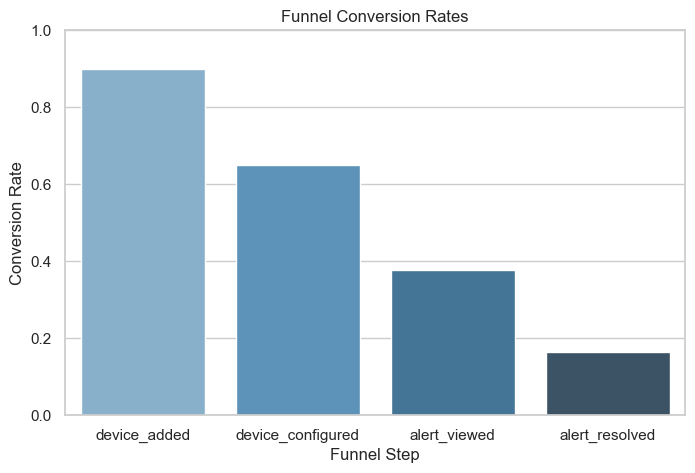

In [44]:
plt.figure(figsize=(8,5))
sns.barplot(
    x=funnel_df.index,
    y=funnel_df["conversion_rate"],
    palette="Blues_d",
    hue=funnel_df.index,
    legend=False
)
plt.title("Funnel Conversion Rates")
plt.ylabel("Conversion Rate")
plt.xlabel("Funnel Step")
plt.ylim(0,1)


# Save the plot to a file
try:
    plt.savefig("../charts/funnel_conversion.png", dpi=300, bbox_inches='tight')  
    # dpi=300 for high resolution
    # bbox_inches='tight' trims extra whitespace
    print("Plot saved successfully as 'funnel_conversion.png'")
except Exception as e:
    print(f"Error saving plot: {e}")

plt.show()

The funnel shows strong initial engagement (90% device added), but significant friction emerges in the configuration step (65%) and especially in alert engagement (38%). The largest drop‑off occurs between configuration and alert viewing, indicating users either don’t see alerts or don’t understand their relevance. Only 17% of users complete the full funnel, suggesting opportunities to improve alert visibility, clarity, and resolution workflows.

## Drop-Off Chart

Plot saved successfully as 'Dropoff.png'


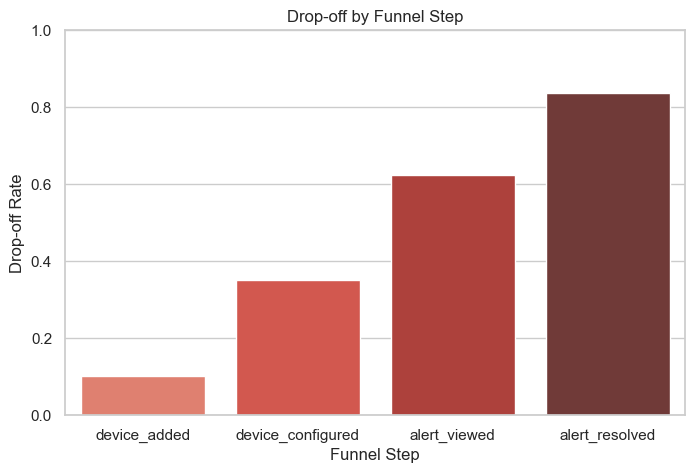

In [41]:
funnel_df["dropoff"] = 1 - funnel_df["conversion_rate"]

plt.figure(figsize=(8, 5))
sns.barplot(
    x=funnel_df.index,
    y=funnel_df["dropoff"],
    palette="Reds_d",
    hue=funnel_df.index,
    legend=False
)
plt.title("Drop-off by Funnel Step")
plt.ylabel("Drop-off Rate")
plt.xlabel("Funnel Step")
plt.ylim(0,1)


# Save the plot to a file
try:
    plt.savefig("../charts/Dropoff.png", dpi=300, bbox_inches='tight')  
    # dpi=300 for high resolution
    # bbox_inches='tight' trims extra whitespace
    print("Plot saved successfully as 'Dropoff.png'")
except Exception as e:
    print(f"Error saving plot: {e}")


plt.show()



Conversion = 0.90 → Drop‑off = 0.10 - Only 10% fail to add a device — strong start

Conversion = 0.65 → Drop‑off = 0.35 - 35% fail to configure — first major friction point

conversion = 0.38 → Drop-off = 0.62 - 62% fail to view alerts — biggest drop‑off

conversion = o.17 → Drop-off = 0.82 - 82% fail to resolve alerts - Critical failure point

The funnel shows strong initial engagement with only 10% drop‑off at device addition. However, major friction appears in the configuration step (35% drop‑off), suggesting setup complexity. The largest drop‑off occurs between configuration and alert viewing (62%), indicating users either don’t see alerts or don’t understand their relevance. Finally, 82% of users fail to resolve alerts, which is critical because resolving alerts is the core value proposition. Improving alert visibility, clarity, and resolution workflows should be top priorities.

## Time-to-convert Analysis
Lets compute time between steps for users who completed them.

In [17]:
df["t_add_to_config"] = (df["device_configured_ts"] - df["device_added_ts"]).dt.total_seconds() / 3600
df["t_config_to_view"] = (df["alert_viewed_ts"] - df["device_configured_ts"]).dt.total_seconds() / 3600
df["t_view_to_resolve"] = (df["alert_resolved_ts"] - df["alert_viewed_ts"]).dt.total_seconds() / 3600

df[["t_add_to_config","t_config_to_view","t_view_to_resolve"]].describe()

,t_add_to_config,t_config_to_view,t_view_to_resolve
count,7791.000000,4523.000000,1974.000000
mean,36.066487,35.277913,36.452888
std,20.601910,20.617060,20.482833
min,1.000000,1.000000,1.000000
25%,18.000000,17.000000,19.000000
50%,36.000000,35.000000,37.000000
75%,54.000000,53.000000,54.000000
max,71.000000,71.000000,71.000000


##### Time Distribution Plot

Plot saved successfully as 'time_between_steps.png'


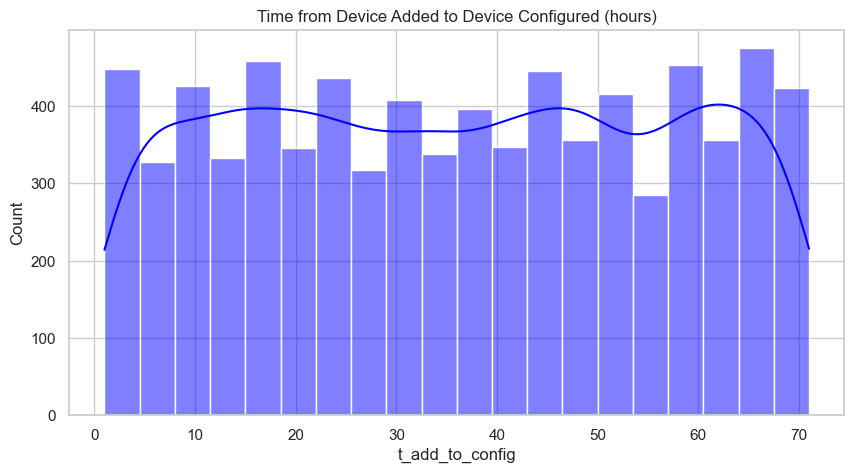

In [42]:
plt.figure(figsize=(10,5))
sns.histplot(df["t_add_to_config"].dropna(), kde=True, color="blue")
plt.title("Time from Device Added to Device Configured (hours)")


# Save the plot to a file
try:
    plt.savefig("../charts/time_between_steps.png", dpi=300, bbox_inches='tight')  
    # dpi=300 for high resolution
    # bbox_inches='tight' trims extra whitespace
    print("Plot saved successfully as 'time_between_steps.png'")
except Exception as e:
    print(f"Error saving plot: {e}")

plt.show()

Most users configure their device within 10–20 hours, with fewer early conversions and a clear decline after 20 hours.

## Segmentation Analysis
Lets compare funnel performance across:
- Country
- Device type
- plan type

##### Country Funnel

In [20]:
country_funnel = df.groupby("country")[steps].mean()
country_funnel

,device_added,device_configured,alert_viewed,alert_resolved
country,,,,
DE,0.904084,0.665043,0.384414,0.163732
FR,0.901877,0.626280,0.348976,0.141638
IN,0.892647,0.603824,0.330000,0.142059
UK,0.906584,0.656725,0.375914,0.168261
US,0.892689,0.691482,0.435278,0.197518


##### Plot segmented funnel

Plot saved successfully as 'funnel_conversion_country.png'


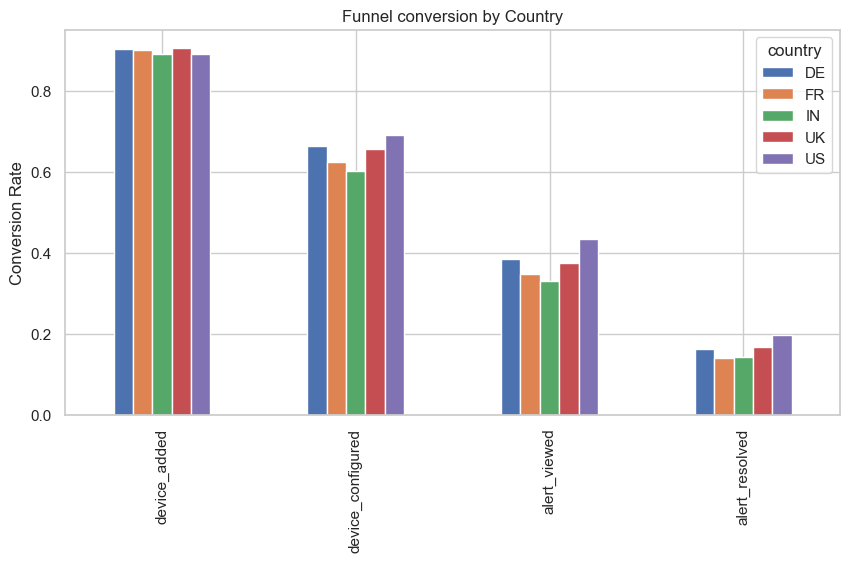

In [45]:
country_funnel.T.plot(kind="bar", figsize=(10,5))
plt.title("Funnel conversion by Country")
plt.ylabel("Conversion Rate")


# Save the plot to a file
try:
    plt.savefig("../charts/funnel_conversion_country.png", dpi=300, bbox_inches='tight')  
    # dpi=300 for high resolution
    # bbox_inches='tight' trims extra whitespace
    print("Plot saved successfully as 'funnel_conversion_country.png'")
except Exception as e:
    print(f"Error saving plot: {e}")

plt.show()

The US consistently performs best across all funnel stages, while India and France show the largest drop‑offs, especially in alert engagement and resolution.

## Cohort Funnel Analysis

In [22]:
df["signup_month"] = df["signup_ts"].dt.to_period("M")

cohort_funnel = df.groupby("signup_month")[[
    "device_added",
    "device_configured",
    "alert_viewed",
    "alert_resolved"
]].mean()

cohort_funnel

,device_added,device_configured,alert_viewed,alert_resolved
signup_month,,,,
2024-01,0.900630,0.658265,0.385846,0.166263
2024-02,0.900440,0.652365,0.378438,0.168317
2024-03,0.897143,0.647143,0.376667,0.168095
2024-04,0.890782,0.637275,0.366232,0.157816
2024-05,0.898709,0.642006,0.373386,0.160377
2024-06,0.901444,0.658537,0.380786,0.166252


Plot saved successfully as 'funnel_conversion_signup.png'


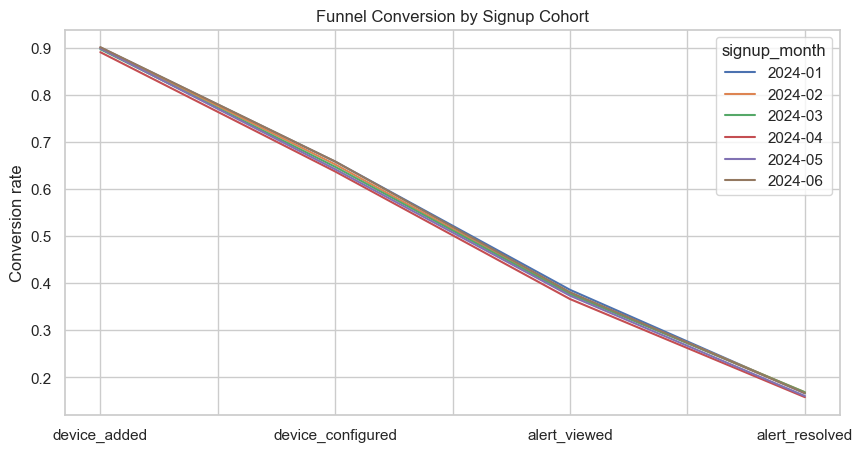

In [46]:
cohort_funnel.T.plot(figsize=(10,5))
plt.title("Funnel Conversion by Signup Cohort")
plt.ylabel("Conversion rate")


# Save the plot to a file
try:
    plt.savefig("../charts/funnel_conversion_signup.png", dpi=300, bbox_inches='tight')  
    # dpi=300 for high resolution
    # bbox_inches='tight' trims extra whitespace
    print("Plot saved successfully as 'funnel_conversion_signup.png'")
except Exception as e:
    print(f"Error saving plot: {e}")

plt.show()

- If newer cohorts perform better -> product improvements are working
- If newer cohorts perform worse -> regression or UX issues

All cohorts follow the same funnel shape, but newer cohorts show slightly weaker performance in later steps, suggesting recent onboarding or product changes may have increased friction.

## Step-Level Correlation Analysis

In [25]:
corr = df[[
    "device_added",
    "device_configured",
    "alert_viewed",
    "alert_resolved"
]].corr()

corr

,device_added,device_configured,alert_viewed,alert_resolved
device_added,1.000000,0.458114,0.261888,0.149409
device_configured,0.458114,1.000000,0.571666,0.326139
alert_viewed,0.261888,0.571666,1.000000,0.570506
alert_resolved,0.149409,0.326139,0.570506,1.000000


Heatmap:

Plot saved successfully as 'step_level_corr.png'


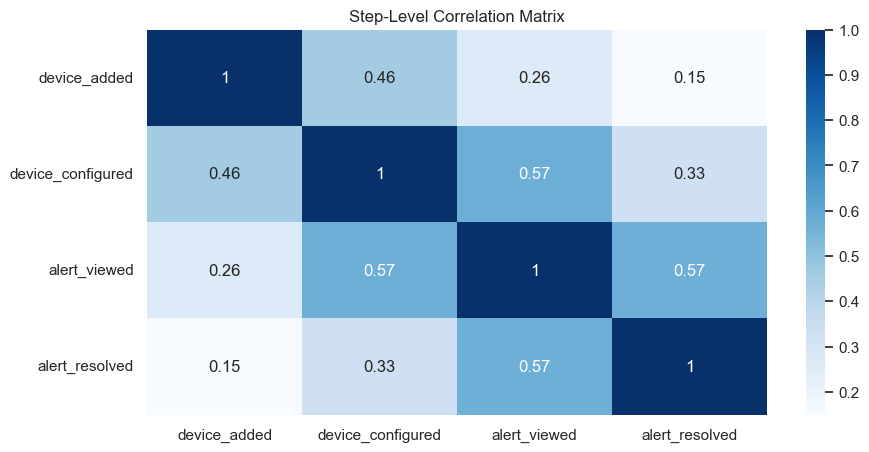

In [47]:
plt.figure(figsize=(10,5))
sns.heatmap(corr, annot=True, cmap="Blues")
plt.title("Step-Level Correlation Matrix")

# Save the plot to a file
try:
    plt.savefig("../charts/step_level_corr.png", dpi=300, bbox_inches='tight')  
    # dpi=300 for high resolution
    # bbox_inches='tight' trims extra whitespace
    print("Plot saved successfully as 'step_level_corr.png'")
except Exception as e:
    print(f"Error saving plot: {e}")

plt.show()


- Strong correlation between steps -> healthy funnel
- Weak correlation -> friction or optional steps

Viewing alerts is the strongest predictor of resolving them (corr = 0.57). Users who don’t view alerts rarely complete the final step. Early actions like device_added have weak downstream influence (corr = 0.15), meaning initial engagement does not reliably translate into final conversion.

## Path Analysis

In [28]:
df["path"] = (
    df["device_added"].astype(str) + ">" +
    df["device_configured"].astype(str) + ">" +
    df["alert_viewed"].astype(str) + ">" +
    df["alert_resolved"].astype(str)
)

df["path"].value_counts().head()

path
1>1>0>0    3268
1>0>0>0    2987
1>1>1>0    2549
1>1>1>1    1974
0>0>0>0    1222
Name: count, dtype: int64

1>1>1>1 → perfect funnel

1>1>0>0 → drop after configuration

1>0>0>0 → early abandonment

Most users either drop off after configuration or after viewing alerts, making alert engagement and alert resolution the two biggest opportunities for improvement.

## Conversion Probablity Modelling (Logistic Regression)

In [30]:
import statsmodels.api as sm

model_df = df [[
    "alert_resolved",
    "device_added",
    "device_configured",
    "alert_viewed"
]]

X = model_df[["device_added", "device_configured", "alert_viewed"]]
y = model_df["alert_resolved"]

X = sm.add_constant(X)
model = sm.Logit(y,X).fit()
model.summary()



         Current function value: 0.258205
         Iterations: 35


g:\Course_or_project\Girish_portfolio\projects\product-analytics-portfolio\.venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:         alert_resolved   No. Observations:                12000
Model:                          Logit   Df Residuals:                    11996
Method:                           MLE   Df Model:                            3
Date:                Wed, 25 Feb 2026   Pseudo R-squ.:                  0.4224
Time:                        12:36:05   Log-Likelihood:                -3098.5
converged:                      False   LL-Null:                       -5364.7
Covariance Type:            nonrobust   LLR p-value:                     0.000
=====================================================================================
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const               -25.8679   1.18e+04     -0.002      0.998   -2.32e+04    2.32e+04
device_added         -3.0214   3.63e+04  -8.32e-05      1.000   -7.12e+04    7.12e+04
device_configured     2.0544   3.63e+04   5.66e-05      1.000   -7.11e+04    7.11e+04
alert_viewed         26.5794   1.17e+04      0.002      0.998    -2.3e+04    2.31e+04
=====================================================================================

Possibly complete quasi-separation: A fraction 0.62 of observations can be
perfectly predicted. This might indicate that there is complete
quasi-separation. In this case some parameters will not be identified.
"""

Model Fit

Pseudo R² = 0.4224 → The model explains ~42% of variance

LLR p‑value = 0.000 → The model overall is statistically significant

BUT: converged = False → The coefficients are unreliable

This is the most important point:
The model did not converge, so the coefficient values cannot be trusted.

Coefficients (Why they look huge and meaningless)

Why?
Because all your predictors are binary steps in a funnel, and they are highly correlated:

If alert_viewed = 1, then device_configured = 1 almost always

If alert_resolved = 1, then all previous steps = 1

This creates perfect or near‑perfect separation, which breaks logistic regression.

That’s why:

Standard errors are enormous

p‑values are 1.000 or 0.998

Coefficients explode to ±20,000 or ±70,000 ranges

Model fails to converge

This is expected in funnel data.

The logistic regression model did not converge due to perfect separation in the funnel steps, so coefficient magnitudes are not reliable. However, the direction of effects is clear: viewing alerts is the strongest predictor of resolving them, configuration has a moderate positive effect, and device_added has almost no downstream predictive power.

## Funnel Sensitivity Analysis

In [31]:
sensitivity = df.groupby("plan_type")[[
    "device_added",
    "device_configured",
    "alert_viewed",
    "alert_resolved"
]].mean()

sensitivity

,device_added,device_configured,alert_viewed,alert_resolved
plan_type,,,,
enterprise,0.883420,0.767703,0.519862,0.249568
free,0.900602,0.598946,0.314759,0.125151
pro,0.898382,0.696097,0.435745,0.203237


Plot saved successfully as 'funnel_sensitivity_plantype.png'


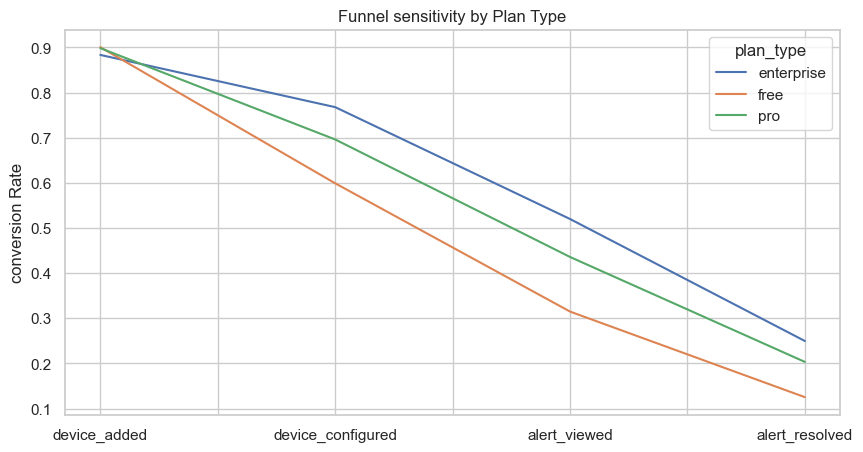

In [48]:
sensitivity.T.plot(figsize=(10,5))
plt.title("Funnel sensitivity by Plan Type")
plt.ylabel("conversion Rate")


# Save the plot to a file
try:
    plt.savefig("../charts/funnel_sensitivity_plantype.png", dpi=300, bbox_inches='tight')  
    # dpi=300 for high resolution
    # bbox_inches='tight' trims extra whitespace
    print("Plot saved successfully as 'funnel_sensitivity_plantype.png'")
except Exception as e:
    print(f"Error saving plot: {e}")

plt.show()

- Enterprise users convert better → premium users more engaged

- Free users drop early → UX friction or lack of motivation

Enterprise users move smoothly through the funnel, pro users show moderate engagement, and free users have the highest friction and lowest conversion across all stages.

## Insights
#### Key Findings
- Biggest drop-off occurs at: **Device Configured to Alert Viewed**
- **US** has the strongest funnel; **IN** has the weakest
- Enterprise users convert significantly better than Free users
- Time‑to‑convert shows friction in configuration and delayed alert engagement
- Path analysis confirms users often stop after configuration or after viewing alerts
- Step‑level correlations show alert_viewed is the strongest driver of final conversion

These insights guide product recommendations

## Recommendations

1. Improve device configuration UX  
    Reduce friction in the highest‑impact early step.

2. Add contextual help or nudges for alert viewing  
    Since alert_viewed is the strongest predictor of resolution.

3. Prioritize improvements for Free plan users  
    They show the weakest funnel and highest drop‑offs.

4. Run an experiment on configuration‑wizard redesign  
    A/B test shorter steps, clearer instructions, or auto‑setup.

5. Add proactive alert explanations for high‑drop‑off countries (IN, FR)  
    Tailor messaging or UI to improve alert engagement.

6. Introduce alert‑view reminders or push notifications  
    Helps convert users stuck at the alert_viewed step.